# CNN model using Pytorch

## Import libraries

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset

from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

PyTorch Version:  2.3.0+cu121
Torchvision Version:  0.18.0+cu121


## Load the Data

In [2]:
!pip install kaggle
!kaggle datasets download -d guare13/handwritten-letters-recognition
!unzip handwritten-letters-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid_letters/letter_3363.png  
  inflating: valid_letters/letter_33630.png  
  inflating: valid_letters/letter_33631.png  
  inflating: valid_letters/letter_33632.png  
  inflating: valid_letters/letter_33633.png  
  inflating: valid_letters/letter_33634.png  
  inflating: valid_letters/letter_33635.png  
  inflating: valid_letters/letter_33636.png  
  inflating: valid_letters/letter_33637.png  
  inflating: valid_letters/letter_33638.png  
  inflating: valid_letters/letter_33639.png  
  inflating: valid_letters/letter_3364.png  
  inflating: valid_letters/letter_33640.png  
  inflating: valid_letters/letter_33641.png  
  inflating: valid_letters/letter_33642.png  
  inflating: valid_letters/letter_33643.png  
  inflating: valid_letters/letter_33644.png  
  inflating: valid_letters/letter_33645.png  
  inflating: valid_letters/letter_33646.png  
  inflating: valid_letters/letter_33648.png  
  inflating: valid_letters/lett

## View Data

In [3]:
train_data = pd.read_csv('written_letters_train.csv') # Load the training data from the csv file
valid_data = pd.read_csv('written_letters_validation.csv') # Load the validation data from the csv file

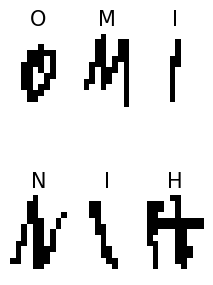

In [4]:
# Display the first 6 images from the training data with their corresponding labels

plt.figure(figsize=(2.5, 3.5)) # Set the size of the plot

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_letters/'+train_data.loc[i, 'id']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train_data.loc[i, 'nombre'], fontsize=15)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.5)

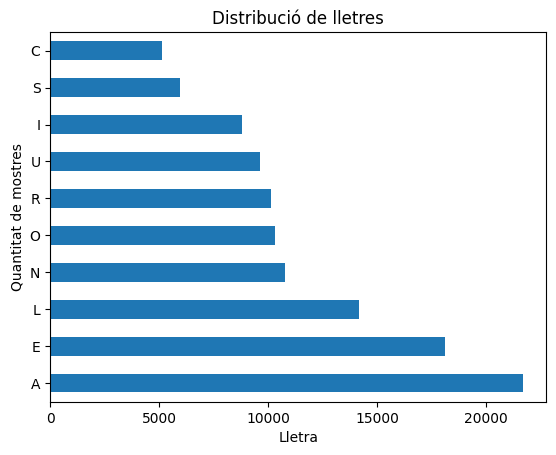

nombre
A    21687
E    18122
L    14201
N    10797
O    10319
R    10160
U     9636
I     8816
S     5945
C     5128
Name: count, dtype: int64


In [10]:
# Count the number of samples for each letter in the training data

letter_count = train_data['nombre'].value_counts()

letter_count[:10].plot(kind='barh')
plt.title('Distribució de lletres')
plt.xlabel('Lletra')
plt.ylabel('Quantitat de mostres')
plt.show()

print(letter_count[:10])

## Preprocessing Images for Training

In [11]:
# Create a custom dataset class for the handwriting dataset 
class HandwritingDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir # Directory with all the images
        self.df = pd.read_csv(csv_file) # Load the csv file
        self.transform = transform # Apply transformations to the images
        self.label_encoder = LabelEncoder() # Encode the labels
        self.labels_encoded = self.label_encoder.fit_transform(self.df.iloc[:, 1]) 
        
    def __len__(self):
        return len(self.df) # Return the number of samples in the dataset

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0]) # Get the image name
        image = Image.open(img_name).convert("L")  # Convert to grayscale
        label = self.labels_encoded[idx]  # Use the encoded labels

        if self.transform:
            image = self.transform(image) # Apply transformations to the images

        return image, label

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to a standard size
    transforms.ToTensor(),  # Convert image to tensor
])

Split the datasets:

In [13]:
# Combine the training and validation DataFrames
combined_data = pd.concat([train_data, valid_data])

# Separate features and labels
X = combined_data.drop(columns=['nombre'])
y = combined_data['nombre']

In [14]:
# Verify the class distribution
print('Training class distribution:\n', train_data['nombre'].value_counts())
print('Validation class distribution:\n', valid_data['nombre'].value_counts())

Training class distribution:
 nombre
A    22216
E    18677
L    14574
N    11079
O    10659
R    10438
U     9905
I     9020
S     6086
C     5290
H     4984
M     4635
T     4588
D     3708
G     2651
Y     2497
B     2325
P     1915
V     1907
F     1516
X     1038
Z      978
K      950
J      659
       614
-      584
Q      195
W      141
'       27
Name: count, dtype: int64
Validation class distribution:
 nombre
A    2222
E    1868
L    1457
N    1108
O    1066
R    1044
U     991
I     902
S     609
C     529
H     498
M     464
T     459
D     371
G     265
Y     250
B     232
P     191
V     191
F     151
X     104
Z      98
K      95
J      66
       61
-      58
Q      19
W      14
'       3
Name: count, dtype: int64


Balance the labels with weights:

In [15]:
from sklearn.utils.class_weight import compute_class_weight

# Get the class labels
class_labels = train_data['nombre'].unique() # Get the unique class labels from the training data
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_data['nombre']) # Compute the class weights

# Convert to tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device) # Convert the class weights to a tensor and move to device

In [17]:
# Create a custom dataset from the handwriting dataset using the HandwritingDataset class
train_dataset = HandwritingDataset(root_dir='train_letters/', csv_file="written_letters_train.csv", transform=transform)
valid_dataset = HandwritingDataset(root_dir='valid_letters/', csv_file="written_letters_validation.csv", transform=transform)

In [18]:
# Create DataLoader objects for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

Verify de data loaders work correctly:

In [19]:
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(images.shape)  # This will give you the shape of the batch of images
    print(labels.shape)  # And this will give you the shape of the batch of labels
    break  # Just to demonstrate, stop after the first batch

Batch 0:
torch.Size([8, 1, 28, 28])
torch.Size([8])


## Training function

In [20]:
# Early stopping class to stop the training process if the validation loss does not improve after a certain number of epochs
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience # Number of epochs to wait before stopping the training process
        self.delta = delta # Minimum change in the monitored quantity to qualify as an improvement
        self.best_score = None # Best score obtained so far
        self.counter = 0 # Counter to keep track of the number of epochs with no improvement
        self.early_stop = False # Boolean to stop the training process
        self.best_model_wts = None # Best model weights obtained so far

    def __call__(self, val_loss, model):
        score = -val_loss # The score is the negative validation loss
        if self.best_score is None:
            self.best_score = score # Set the best score to the initial score
            self.save_checkpoint(val_loss, model) # Save the model weights
        elif score < self.best_score + self.delta:
            self.counter += 1 # Increment the counter if the score does not improve
            if self.counter >= self.patience: 
                self.early_stop = True # Stop the training process if the counter exceeds the patience
        else:
            self.best_score = score # Update the best score
            self.save_checkpoint(val_loss, model) # Save the model weights
            self.counter = 0 # Reset the counter

    def save_checkpoint(self, val_loss, model):
        self.best_model_wts = copy.deepcopy(model.state_dict()) # Save the best model weights
        torch.save(self.best_model_wts, 'checkpoint.pt') # Save the model weights to a file

In [21]:
# Function to train the model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()  # Get the start time

    acc_history = {"train": [], "valid": []}  # Store accuracy per epoch
    losses = {"train": [], "valid": []}  # Store average losses per epoch

    # Save the best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # Initialize the best accuracy

    # Initialize the EarlyStopping object with a patience of 5 epochs
    early_stopping = EarlyStopping(patience=5, delta=0)

    for epoch in range(num_epochs):
        # Print the current epoch
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:  # Iterate over the training and validation phases
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0  # Initialize the running loss
            running_corrects = 0  # Initialize the number of correct predictions

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # Move the inputs to the device
                labels = labels.to(device)  # Move the labels to the device

                optimizer.zero_grad()  # Zero the parameter gradients

                # Enable gradient computation based on the phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # Forward pass
                    loss = criterion(outputs, labels)  # Compute the loss

                    _, preds = torch.max(outputs, 1)  # Get the predictions

                    if phase == 'train':
                        loss.backward()  # Backward pass
                        optimizer.step()  # Optimize the model

                running_loss += loss.item() * inputs.size(0)  # Update the running loss
                # Update the number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Compute the average loss
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double(
            ) / len(dataloaders[phase].dataset)  # Compute the accuracy

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Save the average loss for the epoch
            losses[phase].append(epoch_loss)

            if phase == 'valid':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc # Update the best accuracy 
                    best_model_wts = copy.deepcopy(model.state_dict()) # Save the best model weights
                early_stopping(epoch_loss, model) # Check if the model should stop early

            acc_history[phase].append(epoch_acc) # Save the accuracy for the epoch

        print()

        if early_stopping.early_stop: # Stop the training process if early stopping criterion is met
            print("Early stopping")
            break

    time_elapsed = time.time() - since # Compute the total time taken
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60)) # Print the total time taken
    print('Best val Acc: {:4f}'.format(best_acc)) # Print the best accuracy

    if early_stopping.best_model_wts is not None: # Load the best model weights
        model.load_state_dict(early_stopping.best_model_wts)
    else:
        model.load_state_dict(best_model_wts) 
    return model, acc_history, losses 

## Initialize model

In [ ]:
# Create a function to initialize the model
def initialize_model(num_classes):

    # Load the ResNet-18 model
    model = models.resnet18() 

    # Change the input channels to 1 for grayscale images
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(
        7, 7), stride=(2, 2), padding=(3, 3), bias=False)  

    # Change the output layer to have the same number of classes as the dataset and add a dropout layer
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features=512, out_features=num_classes, bias=True))

    input_size = 224 # Set the input size of the model to 224 for the images 

    return model, input_size

In [22]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' " # Different classes in the dataset

num_classes = len(alphabets) # Number of classes in the dataset
print('num classes:', num_classes) 

# Initialize the model
model, input_size = initialize_model(num_classes)
print(model)

num classes: 29
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

## Run Training and Validation

In [23]:
# Send the model to GPU
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Number of epochs to train fors
num_epochs = 20

# Observe that all parameters are being optimized by the optimizer (Adam)
optimizer_ft = optim.Adam(model.parameters(), lr=0.00001)

# Create a dictionary of the DataLoaders
dataloaders_dict = {"train": train_loader, "valid": valid_loader}

# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 0.9646 Acc: 0.6426
valid Loss: 0.4120 Acc: 0.8295

Epoch 1/19
----------
train Loss: 0.4712 Acc: 0.8064
valid Loss: 0.3462 Acc: 0.8811

Epoch 2/19
----------
train Loss: 0.3800 Acc: 0.8501
valid Loss: 0.3203 Acc: 0.9036

Epoch 3/19
----------
train Loss: 0.3297 Acc: 0.8736
valid Loss: 0.3010 Acc: 0.9136

Epoch 4/19
----------
train Loss: 0.3032 Acc: 0.8862
valid Loss: 0.2991 Acc: 0.9148

Epoch 5/19
----------
train Loss: 0.2775 Acc: 0.8967
valid Loss: 0.2946 Acc: 0.9183

Epoch 6/19
----------
train Loss: 0.2605 Acc: 0.9027
valid Loss: 0.2999 Acc: 0.9209

Epoch 7/19
----------
train Loss: 0.2412 Acc: 0.9091
valid Loss: 0.3007 Acc: 0.9231

Epoch 8/19
----------
train Loss: 0.2288 Acc: 0.9130
valid Loss: 0.2925 Acc: 0.9204

Epoch 9/19
----------
train Loss: 0.2187 Acc: 0.9165
valid Loss: 0.2960 Acc: 0.9255

Epoch 10/19
----------
train Loss: 0.2102 Acc: 0.9201
valid Loss: 0.3005 Acc: 0.9251

Epoch 11/19
----------
train Loss: 0.1980 Acc: 0.9231
valid Loss

In [24]:
# Save the model weights to a file
torch.save(model.state_dict(), 'cnn_model_v7.pth')

## Plot the training and validation losses and accuracies

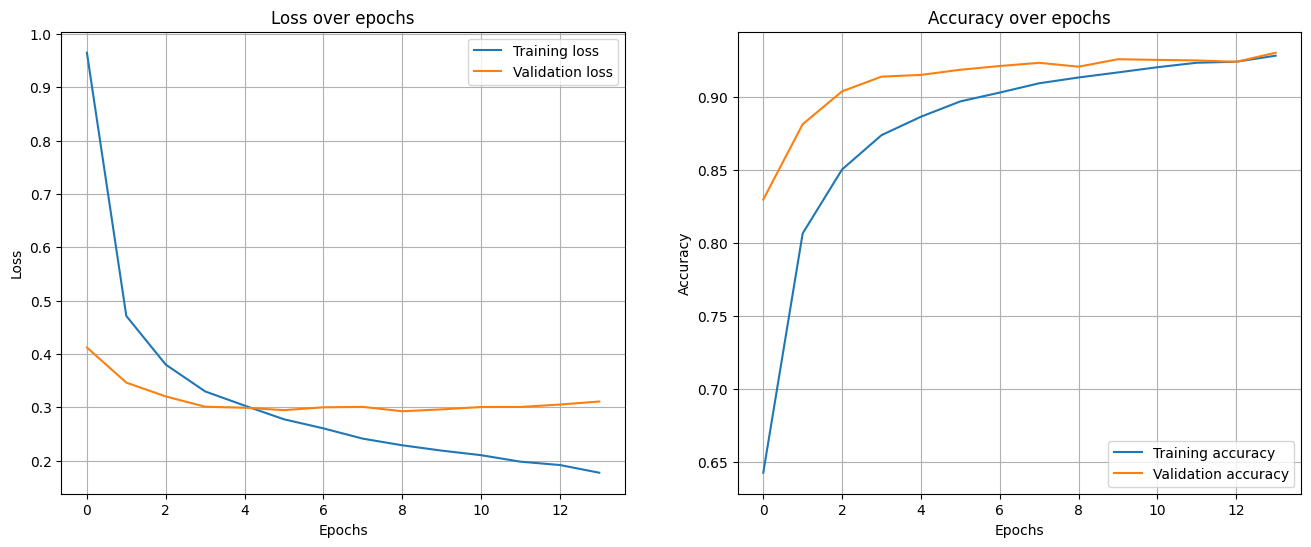

In [25]:

train_losses = losses["train"]
val_losses = losses["valid"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the training and validation losses
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.set_title('Loss over epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

train_accuracies = [acc.cpu().detach().numpy() for acc in hist['train']]
val_accuracies = [acc.cpu().detach().numpy() for acc in hist['valid']]

# Plot the training and validation accuracies
ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(val_accuracies, label='Validation accuracy')
ax2.set_title('Accuracy over epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()
